# **"Fruit Classification Using CNN"**


## _+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+_+


# **Unziping Datset**

In [1]:
import zipfile

zip_file_name = '/content/fruit_dataset.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content')

# **Importing Libraries**

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns

# **Plotting Data**

In [ ]:
def load_random_images(base_path, num_images=5):
    classes = ['apple', 'banana', 'mango', 'orange']
    images = {}

    for fruit in classes:
        fruit_path = os.path.join(base_path, 'Train', fruit)
        all_images = os.listdir(fruit_path)
        selected_images = random.sample(all_images, num_images)
        images[fruit] = [os.path.join(fruit_path, img) for img in selected_images]

    return images

In [ ]:
def plot_images(images):
    num_classes = len(images)
    num_images_per_class = len(images[next(iter(images))])

    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 10))

    for i, (fruit, img_paths) in enumerate(images.items()):
        for j, img_path in enumerate(img_paths):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            # Set title for each image
            axes[i, j].set_title(fruit.capitalize(), fontsize=10, pad=5)

    plt.tight_layout()
    plt.show()

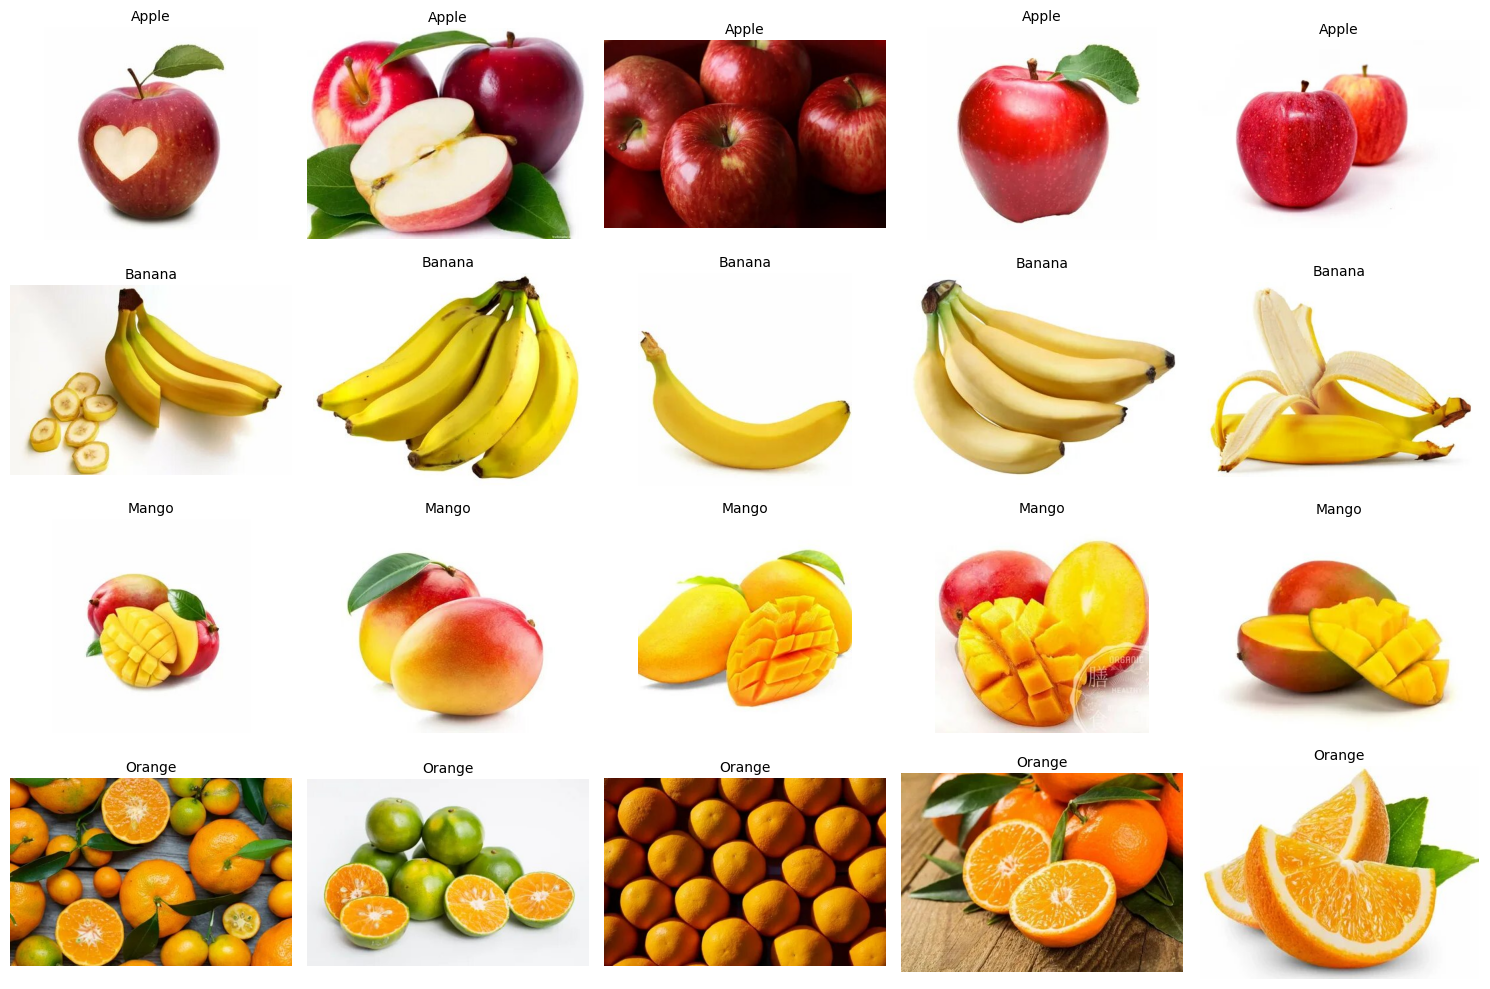

In [ ]:
base_path = '/content/fruit_dataset'
random_images = load_random_images(base_path)
plot_images(random_images)

# **Data Distribustion**

In [ ]:
import os
import matplotlib.pyplot as plt

def count_images(base_path):
    classes = ['apple', 'banana', 'mango', 'orange']
    distribution = {'Train': {}, 'Test': {}}

    for folder in ['Train', 'Test']:
        for fruit in classes:
            fruit_path = os.path.join(base_path, folder, fruit)
            if os.path.exists(fruit_path):
                count = len(os.listdir(fruit_path))
                distribution[folder][fruit] = count
            else:
                distribution[folder][fruit] = 0  # In case the folder doesn't exist

    return distribution

In [ ]:
def plot_distribution(distribution):
    classes = list(distribution['Train'].keys())
    train_counts = [distribution['Train'][fruit] for fruit in classes]
    test_counts = [distribution['Test'][fruit] for fruit in classes]

    x = range(len(classes))  # The x locations for the groups

    # Create bar plots
    plt.figure(figsize=(10, 6))
    bar_width = 0.35  # Width of the bars

    # Create bars for Train and Test
    plt.bar(x, train_counts, width=bar_width, label='Train', color='blue', alpha=0.7)
    plt.bar([p + bar_width for p in x], test_counts, width=bar_width, label='Test', color='orange', alpha=0.7)

    # Adding labels and title
    plt.xlabel('Fruit Class')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution of Fruit Images in Train and Test Folders')
    plt.xticks([p + bar_width / 2 for p in x], classes)  # Center the x-tick labels
    plt.legend()

    plt.tight_layout()
    plt.show()

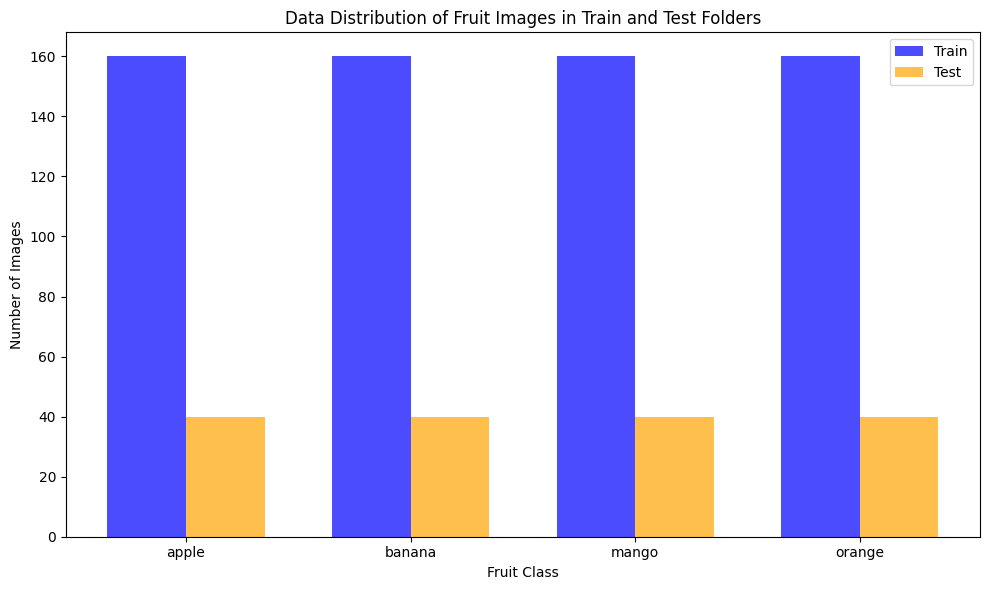

In [ ]:
base_path = '/content/fruit_dataset'  # Adjust this path as necessary
distribution = count_images(base_path)
plot_distribution(distribution)

# **Create Test and Val Generators**

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the entire dataset
dataset = image_dataset_from_directory(
    directory='/content/fruit_dataset/Train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

# Determine the number of validation samples
validation_split = 0.1
num_validation_samples = int(len(dataset) * validation_split)

# Split the dataset into training and validation sets
train_ds = dataset.skip(num_validation_samples)
validation_ds = dataset.take(num_validation_samples)

# Create a test dataset
test_ds = image_dataset_from_directory(
    directory='/content/fruit_dataset/Test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

Found 640 files belonging to 4 classes.
Found 160 files belonging to 4 classes.


In [ ]:
# Function to count the number of samples in a dataset
def count_data(dataset):
    count = 0
    for batch in dataset:
        count += batch[0].shape[0]
    return count

# Print the counts of each dataset
train_count = count_data(train_ds)
validation_count = count_data(validation_ds)
test_count = count_data(test_ds)

print(f"Number of training samples: {train_count}")
print(f"Number of validation samples: {validation_count}")
print(f"Number of test samples: {test_count}")

# Prefetch datasets for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Number of training samples: 576
Number of validation samples: 64
Number of test samples: 160


# **Normalize Images (make pixel Values b/w 0 and 1)**

In [ ]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
test_ds = test_ds.map(process)

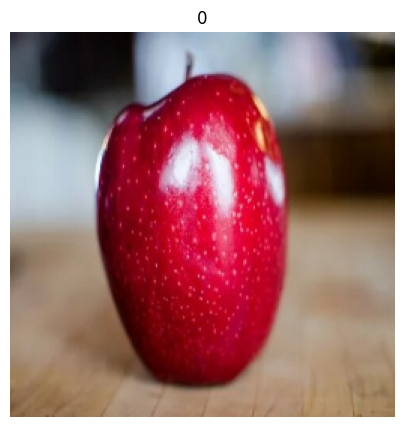

In [ ]:
# Function to display an image after Normalization
def display_image_from_ds(dataset):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(5, 5))
        for i in range(1):
            ax = plt.subplot(1, 1, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(int(labels[i].numpy()))
            plt.axis("off")
        break

# Display one of the normalized images from train_ds
display_image_from_ds(train_ds)

# **Create CNN Model**

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_ds, validation_data=validation_ds, epochs=40, callbacks=[early_stopping])

Epoch 1/40
18/18 [==============================] - 4s 123ms/step - loss: 1.5333 - accuracy: 0.3333 - val_loss: 1.0192 - val_accuracy: 0.4844
Epoch 2/40
18/18 [==============================] - 2s 97ms/step - loss: 0.9905 - accuracy: 0.5243 - val_loss: 0.7813 - val_accuracy: 0.8281
Epoch 3/40
18/18 [==============================] - 2s 105ms/step - loss: 0.7725 - accuracy: 0.6892 - val_loss: 0.7830 - val_accuracy: 0.7656
Epoch 4/40
18/18 [==============================] - 3s 118ms/step - loss: 0.8354 - accuracy: 0.6580 - val_loss: 0.6718 - val_accuracy: 0.7188
Epoch 5/40
18/18 [==============================] - 2s 109ms/step - loss: 0.5547 - accuracy: 0.7951 - val_loss: 0.6085 - val_accuracy: 0.7812
Epoch 6/40
18/18 [==============================] - 2s 96ms/step - loss: 0.3831 - accuracy: 0.8524 - val_loss: 0.3027 - val_accuracy: 0.9219
Epoch 7/40
18/18 [==============================] - 2s 106ms/step - loss: 0.3369 - accuracy: 0.8941 - val_loss: 0.1539 - val_accuracy: 0.9375
Epoch 8/

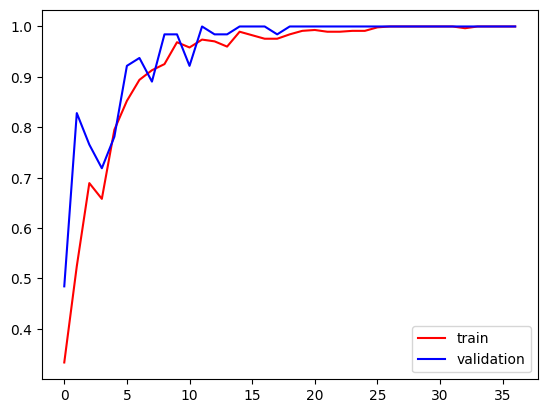

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

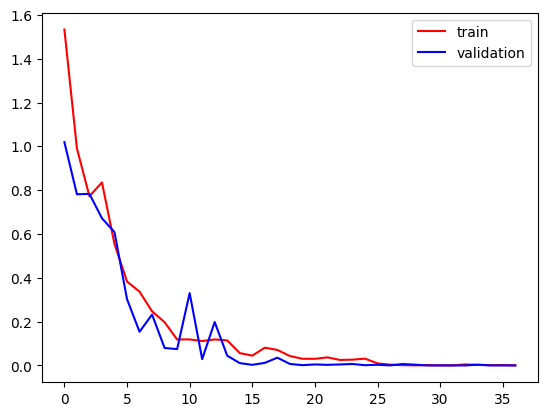

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# **Save Model**

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
y_true = []
y_pred = []

In [ ]:
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

1/1 [==============================] - 0s 42ms/step


Text(41.25, 0.5, 'Actual')

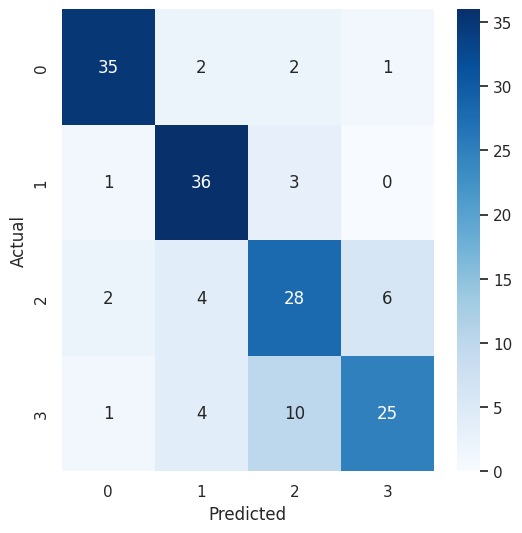

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

5/5 [==============================] - 0s 28ms/step - loss: 2.0360 - accuracy: 0.7750
Test accuracy: 0.7749999761581421
Test loss: 2.0359816551208496


# **Load Model**

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('model.h5')

# **Predictions**

1/1 [==============================] - 0s 18ms/step


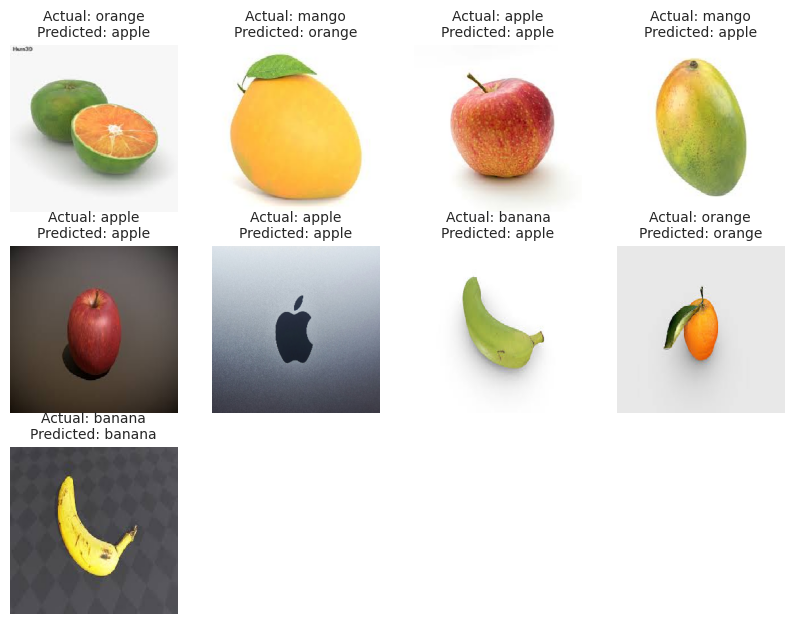

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_and_plot_images(model, image_folder, class_names):
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.jpeg')]

    plt.figure(figsize=(10, 10))

    for i, img_file in enumerate(image_files):
        # Load and preprocess the image
        img_path = os.path.join(image_folder, img_file)
        img = image.load_img(img_path, target_size=(256, 256))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Make prediction
        predictions = model.predict(img_array)
        predicted_label = np.argmax(predictions)

        # Extract actual class from the filename
        actual_label = None
        for class_name in class_names:
            if class_name in img_file:
                actual_label = class_name
                break

        # Plotting
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {actual_label}\nPredicted: {class_names[predicted_label]}", fontsize = 10)
        plt.axis('off')

    plt.show()


image_folder = '/content'  # Folder containing your images
class_names = ['apple', 'banana', 'mango', 'orange']
predict_and_plot_images(loaded_model, image_folder, class_names)

After Thoroughly observing the dataset, I have come to make a conclusion about misclassifications of the images, that is:



*   Apple dataset has both green and red apples
*   Banana dataset has only yellow bananas
*   Mango dataset has reddish-yellowish color mangos
*   Orange dataset has bright yellowish-orange color oranges

Thus, the model is trained such that when it sees green color, it classifies it as apple. Hence the missclassification of green orange, green mango and green banana.




# **Retraining model on new dataset**

I am adding 50 greenish fruits images per class in Train set and 14 images per class in Test set and then will retrain the model to see if it still missclassifies them as apple or not.

## **Plotting Updated Dataset**

In [5]:
def load_random_images(base_path, num_images=5):
    classes = ['apple', 'banana', 'mango', 'orange']
    images = {}

    for fruit in classes:
        fruit_path = os.path.join(base_path, 'Train', fruit)
        all_images = os.listdir(fruit_path)
        selected_images = random.sample(all_images, num_images)
        images[fruit] = [os.path.join(fruit_path, img) for img in selected_images]

    return images


def plot_images(images):
    num_classes = len(images)
    num_images_per_class = len(images[next(iter(images))])

    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(10, 10))

    for i, (fruit, img_paths) in enumerate(images.items()):
        for j, img_path in enumerate(img_paths):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            # Set title for each image
            axes[i, j].set_title(fruit.capitalize(), fontsize=10, pad=5)

    plt.tight_layout()
    plt.show()

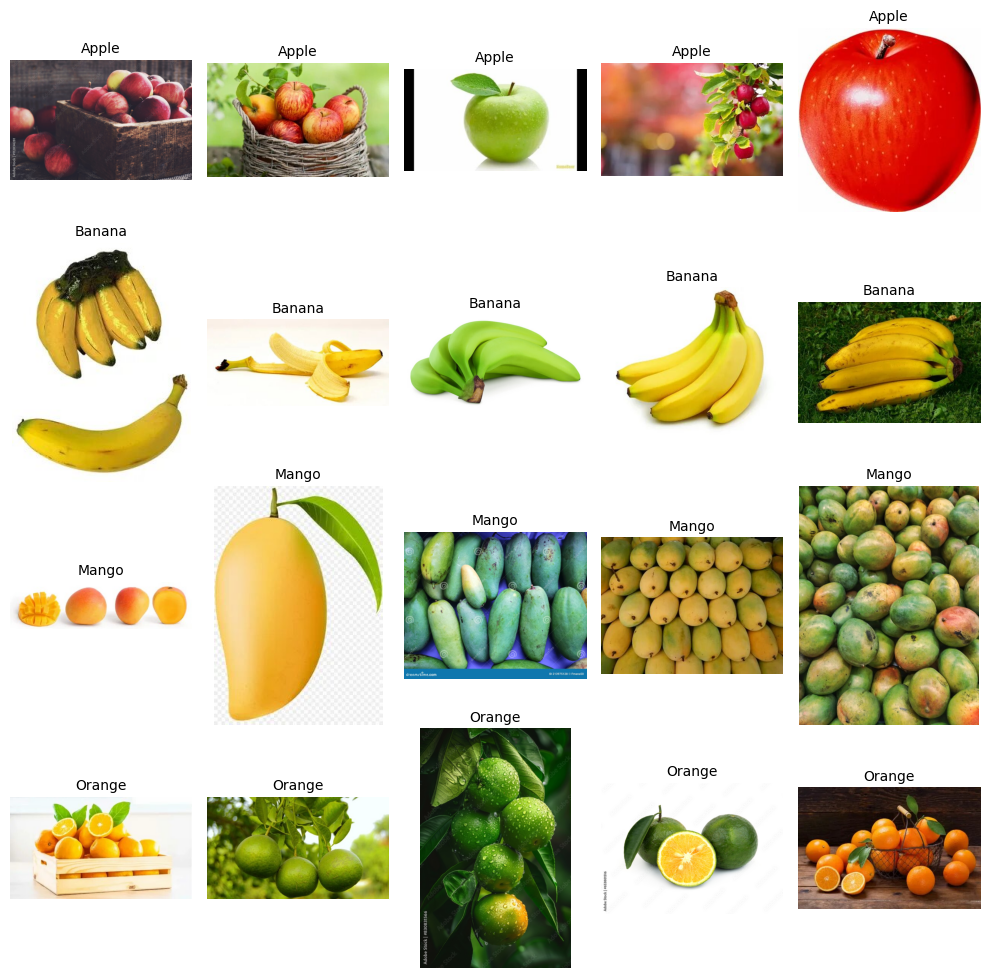

In [9]:
base_path = '/content/fruit_dataset'
random_images = load_random_images(base_path)
plot_images(random_images)

## **Data Distribution**

In [10]:
import os
import matplotlib.pyplot as plt

def count_images(base_path):
    classes = ['apple', 'banana', 'mango', 'orange']
    distribution = {'Train': {}, 'Test': {}}

    for folder in ['Train', 'Test']:
        for fruit in classes:
            fruit_path = os.path.join(base_path, folder, fruit)
            if os.path.exists(fruit_path):
                count = len(os.listdir(fruit_path))
                distribution[folder][fruit] = count
            else:
                distribution[folder][fruit] = 0  # In case the folder doesn't exist

    return distribution


def plot_distribution(distribution):
    classes = list(distribution['Train'].keys())
    train_counts = [distribution['Train'][fruit] for fruit in classes]
    test_counts = [distribution['Test'][fruit] for fruit in classes]

    x = range(len(classes))  # The x locations for the groups

    # Create bar plots
    plt.figure(figsize=(10, 6))
    bar_width = 0.35  # Width of the bars

    # Create bars for Train and Test
    plt.bar(x, train_counts, width=bar_width, label='Train', color='blue', alpha=0.7)
    plt.bar([p + bar_width for p in x], test_counts, width=bar_width, label='Test', color='orange', alpha=0.7)

    # Adding labels and title
    plt.xlabel('Fruit Class')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution of Fruit Images in Train and Test Folders')
    plt.xticks([p + bar_width / 2 for p in x], classes)  # Center the x-tick labels
    plt.legend()

    plt.tight_layout()
    plt.show()

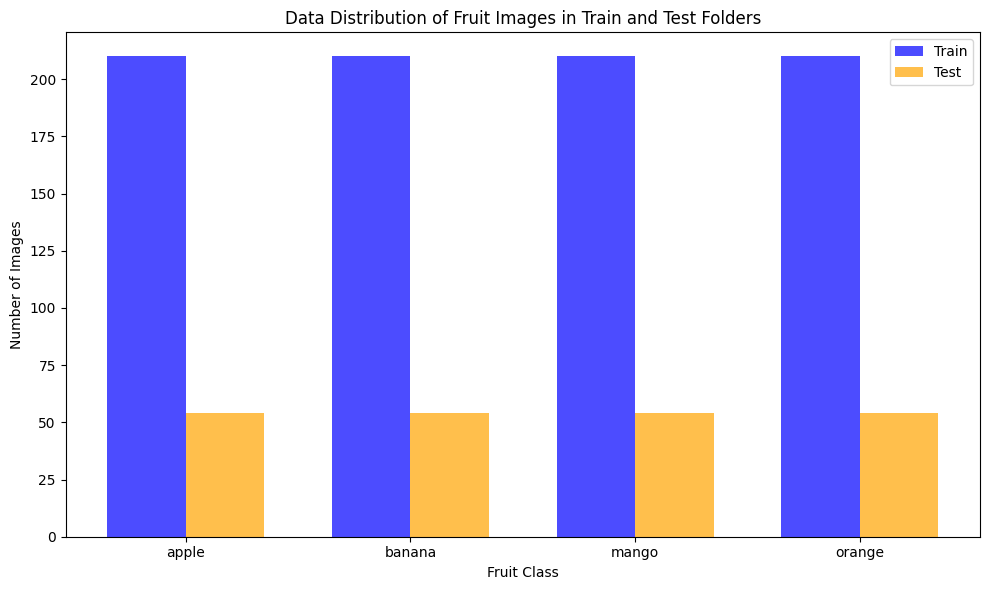

In [11]:
base_path = '/content/fruit_dataset'  # Adjust this path as necessary
distribution = count_images(base_path)
plot_distribution(distribution)

## **Create Test and Val Generators for new data**

In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the entire dataset
dataset = image_dataset_from_directory(
    directory='/content/fruit_dataset/Train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

# Determine the number of validation samples
validation_split = 0.1
num_validation_samples = int(len(dataset) * validation_split)

# Split the dataset into training and validation sets
train_ds = dataset.skip(num_validation_samples)
validation_ds = dataset.take(num_validation_samples)

# Create a test dataset
test_ds = image_dataset_from_directory(
    directory='/content/fruit_dataset/Test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

Found 840 files belonging to 4 classes.
Found 216 files belonging to 4 classes.


In [13]:
# Function to count the number of samples in a dataset
def count_data(dataset):
    count = 0
    for batch in dataset:
        count += batch[0].shape[0]
    return count

# Print the counts of each dataset
train_count = count_data(train_ds)
validation_count = count_data(validation_ds)
test_count = count_data(test_ds)

print(f"Number of training samples: {train_count}")
print(f"Number of validation samples: {validation_count}")
print(f"Number of test samples: {test_count}")

# Prefetch datasets for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Number of training samples: 776
Number of validation samples: 64
Number of test samples: 216


## **Normalize Data Gens**

In [14]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
test_ds = test_ds.map(process)

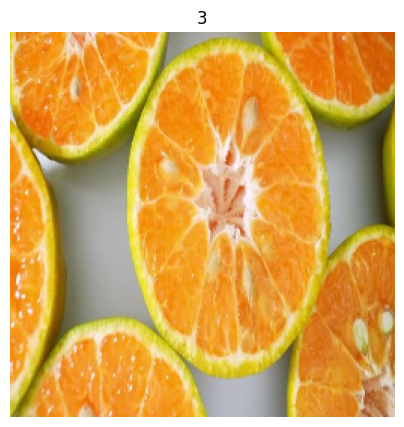

In [15]:
# Function to display an image after Normalization
def display_image_from_ds(dataset):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(5, 5))
        for i in range(1):
            ax = plt.subplot(1, 1, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(int(labels[i].numpy()))
            plt.axis("off")
        break

# Display one of the normalized images from train_ds
display_image_from_ds(train_ds)

## **Training Model Again**

In [124]:
from tensorflow.keras.regularizers import l2

model1 = Sequential()

model1.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model1.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu', kernel_regularizer=l2(0.03)))
model1.add(Dropout(0.3))
model1.add(Dense(4, activation='softmax'))

In [125]:
model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 30, 30, 128)     

In [126]:
model1.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [127]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

history1 = model1.fit(train_ds, validation_data=validation_ds, epochs=100, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
24/25 [===========================>..] - ETA: 0s - loss: 3.5757 - accuracy: 0.3594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 12s 404ms/step - loss: 3.5707 - accuracy: 0.3608 - val_loss: 2.9130 - val_accuracy: 0.6562
Epoch 2/100
25/25 [==============================] - 5s 167ms/step - loss: 2.5842 - accuracy: 0.5335 - val_loss: 2.3514 - val_accuracy: 0.5156
Epoch 3/100
25/25 [==============================] - 4s 145ms/step - loss: 2.0758 - accuracy: 0.5902 - val_loss: 1.7646 - val_accuracy: 0.7344
Epoch 4/100
25/25 [==============================] - 6s 173ms/step - loss: 1.6372 - accuracy: 0.6662 - val_loss: 1.4802 - val_accuracy: 0.7656
Epoch 5/100
25/25 [==============================] - 9s 348ms/step - loss: 1.2943 - accuracy: 0.7577 - val_loss: 1.1128 - val_accuracy: 0.7969
Epoch 6/100
25/25 [==============================] - 5s 189ms/step - loss: 1.0640 - accuracy: 0.8080 - val_loss: 0.9118 - val_accuracy: 0.8594
Epoch 7/100
25/25 [==============================] - 5s 154ms/step - loss: 0.8581 - accuracy: 0.8570 - val_loss: 0.7241 - val_accuracy: 0.9062
Epoch 8/10

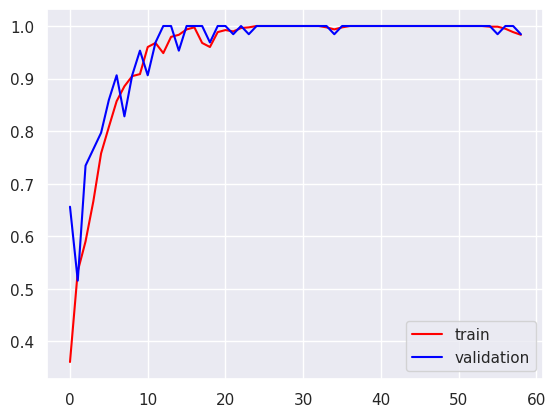

In [128]:
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'],color='red',label='train')
plt.plot(history1.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

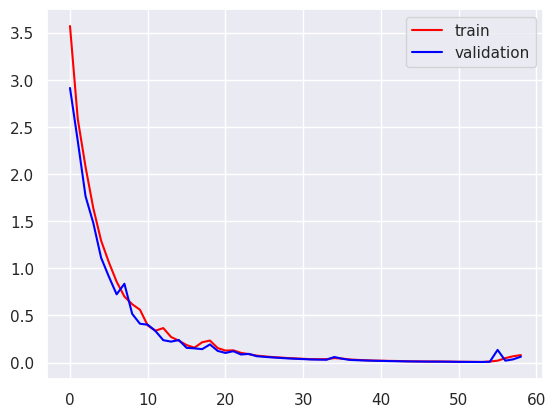

In [129]:
plt.plot(history1.history['loss'],color='red',label='train')
plt.plot(history1.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

## **Load Model**

In [130]:
from tensorflow.keras.models import load_model
loaded_model1 = load_model('best_model.h5')

## **Confusion Matrix**

1/1 [==============================] - 0s 87ms/step


Text(41.25, 0.5, 'Actual')

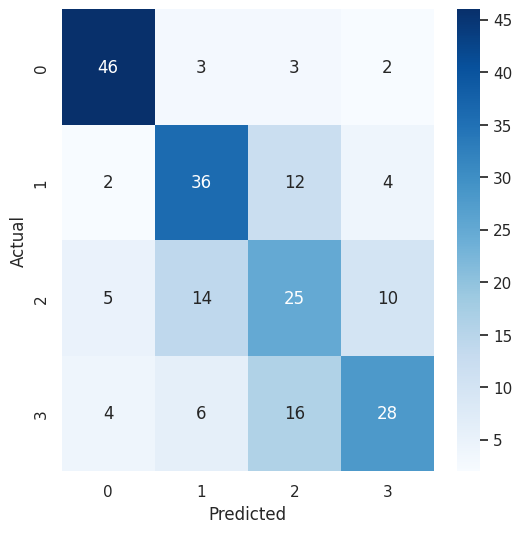

In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = loaded_model1.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [132]:
test_loss, test_accuracy = loaded_model1.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

7/7 [==============================] - 1s 29ms/step - loss: 2.6936 - accuracy: 0.6250
Test accuracy: 0.625
Test loss: 2.693572998046875


## **Predictions on new data**

1/1 [==============================] - 0s 18ms/step


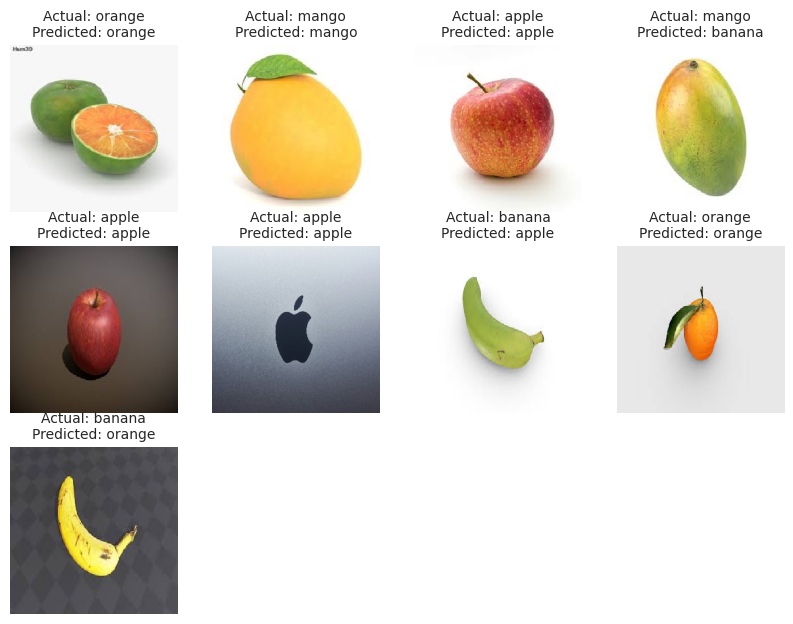

In [133]:
from tensorflow.keras.preprocessing import image

def predict_and_plot_images(model, image_folder, class_names):
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]

    plt.figure(figsize=(10, 10))

    for i, img_file in enumerate(image_files):
        # Load and preprocess the image
        img_path = os.path.join(image_folder, img_file)
        img = image.load_img(img_path, target_size=(256, 256))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Make prediction
        predictions = model.predict(img_array)
        predicted_label = np.argmax(predictions)

        # Extract actual class from the filename
        actual_label = None
        for class_name in class_names:
            if class_name in img_file:
                actual_label = class_name
                break

        # Plotting
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {actual_label}\nPredicted: {class_names[predicted_label]}", fontsize = 10)
        plt.axis('off')

    plt.show()


image_folder = '/content'  # Folder containing your images
class_names = ['apple', 'banana', 'mango', 'orange']
predict_and_plot_images(loaded_model1, image_folder, class_names)

There are still some missclassifications in the predictions. This can further be improved by increasing the data (so that model learns more important features), or by using augmentation. There is more missclassification in mango and banana, this is because the green banana and green mango, both have some kind of similarity in the dataset and de to less dataset (50 green mangoes and bananas), the model was unable to distinguish between them properly.

# **Predictor Function**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def predict_and_plot_image(model, image_path, class_names):
    # Load the model from the specified .h5 file
    model = load_model(model)

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Make prediction
    predictions = model.predict(img_array)
    predicted_label = np.argmax(predictions)

    # Extract the actual class from the filename (if applicable)
    actual_label = None
    img_file_name = os.path.basename(image_path)
    for class_name in class_names:
        if class_name in img_file_name:
            actual_label = class_name
            break

    # Plotting the image with predictions
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.title(f"Actual: {actual_label}\nPredicted: {class_names[predicted_label]}", fontsize=12)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


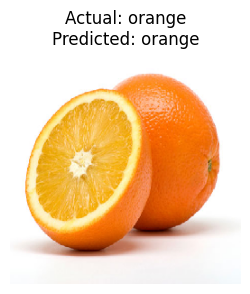

In [3]:
model = 'best_model.h5'
image_path = 'orange_test.jpg'
class_names = ['apple', 'banana', 'mango', 'orange']

predict_and_plot_image(model, image_path, class_names)

1/1 [==============================] - 0s 334ms/step


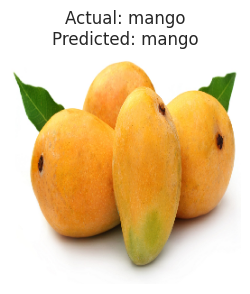

In [150]:
image_path = '/content/mango_test.jpg'
predict_and_plot_image(model, image_path, class_names)

1/1 [==============================] - 0s 88ms/step


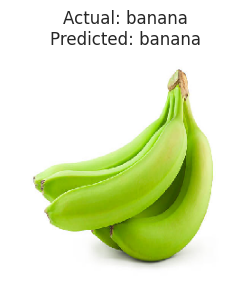

In [148]:
image_path = '/content/banana_2.jpg'
predict_and_plot_image(model, image_path, class_names)

1/1 [==============================] - 0s 145ms/step


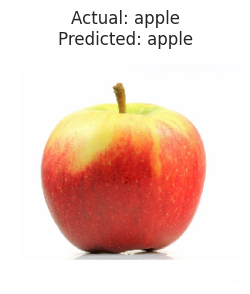

In [147]:
image_path = '/content/apple_test.jpg'
predict_and_plot_image(model, image_path, class_names)